In [176]:
import numpy as np
import pandas as pd
import itertools
#from tqdm import tqdm
import matplotlib.pyplot as plt
#from pandas_datareader import data as web
plt.style.use("default")
import re
import requests
from bs4 import BeautifulSoup
# For reproducibility
np.random.seed(42)


In [177]:
# Manually maintain this list as you go
leverage_pairs = [
    ("AAPU", "AAPL"),
    ("AMUU", "AMD"),
    ("AMZU", "AMZN"),
    ("AVL", "AVGO"),
    ("BITX", "IBIT"),
    ("BOEU", "BA"),
    ("BRKU", "BRK-B"),
    ("BULU", "BULL"),
    ("CSCL", "CSCO"),
    ("ELIL", "LLY"),
    ("ETHU", "ETHA"),
    ("FRDU", "F"),
    ("GGLL", "GOOGL"),
    ("GMEU", "GME"),
    ("LMTL", "LMT"),
    ("METU", "META"),
    ("MUU", "MU"),
    ("MSFU", "MSFT"),
    ("MSTX", "MSTR"),
    ("NVDU", "NVDA"),
    ("NFXL", "NFLX"),
    ("PLTU", "PLTR"),
    ("PALU", "PANW"),
    ("QCMU", "QCOM"),
    ("SHPU", "SHOP"),
    ("TSMX", "TSM"),
    ("TSLL", "TSLA"),
    ("XOMX", "XOM"),
    ("XXRP", "GXRP")
]

leverage_pairs_leverageshares = [
    ("AALG", "AAL"),
    ("ABNG", "ABNB"),
    ("ADBG", "ADBE"),
    ("AMDG", "AMD"),
    ("ARMG", "ARM"),
    ("ASMG", "ASML"),
    ("AVGG", "AVGO"),
    ("BAIG", "BBAI"),
    ("BEG", "BE"),
    ("BIDG", "BIDU"),
    ("BLSG", "BLSH"),
    ("BMNG", "BMNR"),
    ("BOEG", "BA"),
    ("BULG", "BULL"),
    ("CIFG", "CIFR"),
    ("CMGG", "CMG"),
    ("CNCG", "CNC"),
    ("COIG", "COIN"),
    ("COTG", "COST"),
    ("CRCG", "CRCL"),
    ("CRMG", "CRM"),
    ("CRWG", "CRWV"),
    ("DUOG", "DUOL"),
    ("FIGG", "FIG"),
    ("FUTG", "FUTU"),
    ("GEMG", "GEMI"),
    ("GEVG", "GEV"),
    ("GLGG", "GLXY"),
    ("GRAG", "GRAB"),
    ("HOOG", "HOOD"),
    ("IREG", "IREN"),
    ("KLAG", "KLAC"),
    ("LACG", "LAC"),
    ("LULG", "LULU"),
    ("MPG", "MP"),
    ("NBIG", "NBIS"),
    ("NEMG", "NEM"),
    ("NETG", "NET"),
    ("NIOG", "NIO"),
    ("NUG", "NU"),
    ("NVDG", "NVDA"),
    ("OKTG", "OKTA"),
    ("OPEG", "OPEN"),
    ("OSCG", "OSCR"),
    ("PANG", "PANW"),
    ("PBRG", "PBR"),
    ("PLTG", "PLTR"),
    ("PYPG", "PYPL"),
    ("RTXG", "RTX"),
    ("SATG", "SATS"),
    ("SBU", "SBUX"),
    ("SNAG", "SNAP"),
    ("SPOG", "SPOT"),
    ("TERG", "TER"),
    ("TSLG", "TSLA"),
    ("TSMG", "TSM"),
    ("UNHG", "UNH"),
    ("UPSG", "UPS"),
    ("VALG", "VALE"),
    ("XYZG", "XYZ"),
]


leverage_pairs_capped_accel = [
    ("COIO", "COIN"),
    ("MSOO", "MSTR"),
    ("NVDO", "NVDA"),
    ("PLOO", "PLTR"),
    ("TSLO", "TSLA"),
]


# --- New pairs (with crypto mapped to IBIT / ETHA) ---
new_pairs = [
    ("MSTU", "MSTR"),
    ("NVDX", "NVDA"),
    ("TSLT", "TSLA"),
    ("BTCL", "IBIT"),   # changed from BTC -> IBIT
    ("ETU",  "ETHA"),   # changed from ETH -> ETHA
    ("CCUP", "CRCL"),
    ("CRWU", "CRWV"),
    ("AAPX", "AAPL"),
    ("GOOX", "GOOGL"),
    ("MSFX", "MSFT"),
    ("NFLU", "NFLX"),
    ("ROBN", "HOOD"),
    ("ARMU", "ARM"),
    ("DJTU", "DJT"),
    ("RBLU", "RBLX"),
    ("SNOU", "SNOW"),
    ("SMUP", "SMR"),
    ("DKUP", "DKNG"),
    ("BULU", "BULL"), 
    ("GLXU", "GLXY"),
    ("AFRU", "AFRM"),
    ("AXUP", "AXON"),
    ("KTUP", "KTOS"),
    ("TTDU", "TTD"),
    ("BKNU", "BKNG"),
    ("PXIU", "UPXI"),
    ("BMNU", "BMNR"),
    ("SBTU", "SBT"),
    ("CIFU", "CIFR"),
    ("SOLX", "GSOL"),
    ("XRPK", "GXRP"),
    ("GMEU", "GME"),
]

# --- Add them without allowing duplicate ETFs (but allow duplicate underlyings) ---
existing_etfs = {etf for etf, _ in leverage_pairs}
leverage_pairs += [(etf, und) for etf, und in new_pairs if etf not in existing_etfs]

# --- Rebuild expanded list WITHOUT filtering on underlying; only prevent duplicate ETF tickers ---
def dedupe_by_etf(pairs):
    seen = set()
    out = []
    for etf, und in pairs:
        if etf in seen:
            continue
        seen.add(etf)
        out.append((etf, und))
    return out

leverage_pairs_expanded = dedupe_by_etf(
    leverage_pairs
    + leverage_pairs_leverageshares
    + leverage_pairs_capped_accel
)


dx_df = pd.DataFrame(
    [
        {"ETF": etf, "Underlying": und}
        for etf, und in leverage_pairs_expanded
    ]
)

dx_df["Leverage"] = 2.0   # 2x for these dx leveraged products

In [178]:
covered_call_pairs_expanded = [
    ("QYLD", "QQQ"),   # Global X full overwrite
    ("QYLG", "QQQ"),   # 50% overwrite
    ("QQQX", "QQQ"),   # Nuveen dynamic overwrite
    ("JEPQ", "QQQ"),   # JPM active Nasdaq covered-call
    ("XYLD", "SPY"),   # S&P 500 buy-write
    ("XYLG", "SPY"),   # 50% overwrite
    ("JEPI", "SPY"),   # JPM ELN-based premium income
    ("SPYI", "SPY"),   # NEOS buy-write
    ("RYLD", "IWM"),   # Russell 2000 buy-write
]

cc_df = pd.DataFrame(
    [
        {"ETF": etf, "Underlying": und}
        for etf, und in covered_call_pairs_expanded
    ]
)

cc_df["Leverage"] = 1.0   # treat covered calls as 1x


session = requests.Session()
session.headers.update(
    {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        )
    }
)

def get_yieldmax_single_stock_map():
    """
    Scrapes the YieldMax Single Stock Option Income ETFs page and extracts
    (ETF ticker, underlying stock) from the ETF name, e.g.:

        Ticker:  TSLY
        Name:    'YieldMax TSLA Option Income Strategy ETF'
        -> underlying = TSLA

    Returns: DataFrame with columns [Provider, ETF, Underlying]
    """
    base = "https://yieldmaxetfs.com"
    url = base + "/nav-group/yieldmax-single-stock-option-income-etfs/"

    resp = session.get(url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")

    rows = []

    # For each link that looks like a ticker, find the nearby 'YieldMax ...' name
    for a in soup.find_all("a", href=True):
        ticker = a.get_text(strip=True)

        # Tickers are 3–5 uppercase letters (ABNY, TSLY, NVDY, etc.)
        if not re.fullmatch(r"[A-Z]{3,5}", ticker):
            continue

        # Find the ETF name text that follows this ticker
        name_node = a.find_next(string=re.compile(r"^YieldMax "))
        if not name_node:
            continue

        etf_name = name_node.strip()

        # Try to extract underlying from the name:
        # 'YieldMax TSLA Option Income Strategy ETF' -> TSLA
        # 'YieldMax AMZN Option Income ETF'         -> AMZN
        m = re.search(r"YieldMax\s+([A-Z\.]{2,6})\s+Option Income", etf_name)
        if not m:
            continue

        underlying = m.group(1)

        rows.append(("YieldMax", ticker, underlying))

    df = pd.DataFrame(rows, columns=["Provider", "ETF", "Underlying"])
    df = df.drop_duplicates().sort_values(["Provider", "ETF"]).reset_index(drop=True)
    df = df.drop(columns=["Provider"])
    return df

ym_df = get_yieldmax_single_stock_map()
ym_df["Leverage"] = 1.0   # treat YieldMax as 1x (income overlay, not levered beta)



In [212]:
BAD_TOKENS = {
    "NEW", "ETF", "ETFS", "WEEKLYPAY", "WEEKLY", "PAY",
    "ISSUE", "TREASURY", "INCOME", "STRATEGY", "FUND", "TRUST", "INC"
}

def get_roundhill_weeklypay_single_stock_map():
    """
    Scrapes Roundhill WeeklyPay ETFs page and extracts (ETF, Underlying).

    Logic:
    - Identify WeeklyPay link entries
    - Parse first token as ETF
    - Find the first subsequent token that looks like a ticker (2–6 chars, all caps, allows '.' and '-')
      and is not a known bad token
    - If no such token exists, fallback to ETF[:-1] when ETF ends with 'W' (e.g. TSYW -> TSY)
    """
    url = "https://www.roundhillinvestments.com/weeklypay-etfs"

    resp = session.get(url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")

    rows = []

    ticker_re = re.compile(r"^[A-Z][A-Z0-9\.\-]{1,5}$")  # e.g., AAPL, BRK.B, BRK-B

    for a in soup.find_all("a", href=True):
        txt = " ".join(a.get_text(" ", strip=True).split())
        if not txt or "WeeklyPay" not in txt:
            continue

        parts = txt.split()
        if len(parts) < 2:
            continue

        etf = parts[0]
        if not re.fullmatch(r"[A-Z]{3,5}W", etf) and etf != "WPAY":
            # WPAY is a WeeklyPay fund but not single-stock; keep your choice here.
            # We'll ignore it by default.
            continue
        if etf == "WPAY":
            continue

        # Look for an explicit underlying ticker anywhere after the ETF token
        underlying = None
        for tok in parts[1:8]:  # scan a few tokens; enough for current formatting
            t = tok.strip("®™:,;()[]")
            if not ticker_re.fullmatch(t):
                continue
            if t in BAD_TOKENS:
                continue
            if t == etf:
                continue
            underlying = t
            break

        # Fallback: some entries omit the underlying ticker; use ETF[:-1] when it ends in W
        if underlying is None and etf.endswith("W"):
            underlying = etf[:-1]

        if underlying is None:
            continue

        rows.append((etf, underlying))

    df = pd.DataFrame(rows, columns=["ETF", "Underlying"])
    return df.drop_duplicates().sort_values("ETF").reset_index(drop=True)


rh_df = get_roundhill_weeklypay_single_stock_map()
rh_df["Leverage"] = 1.0  # treat WeeklyPay as 1x (income overlay, not levered beta)
income_df = pd.concat([cc_df, ym_df, rh_df], ignore_index=True)

In [217]:
all_df = pd.concat([dx_df, income_df], ignore_index=True)
# make sure to exclude jp morgan
all_df = all_df.dropna(subset=["Underlying"])
all_df = all_df[all_df["Underlying"].astype(str).str.strip() != ""]

# Drop duplicate ETFs or duplicate rows if needed
all_df = all_df.drop_duplicates(subset=["ETF"]).reset_index(drop=True)
# Replace dots with dashes for Yahoo Finance compatibility
all_df["ETF"] = all_df["ETF"].str.replace(".", "-", regex=False)
all_df["Underlying"] = all_df["Underlying"].str.replace(".", "-", regex=False)

# Now create clean ticker lists
all_tickers = all_df["ETF"].tolist()
all_underlyings = all_df["Underlying"].tolist()

# UNIQUE list of underlyings
all_underlyings_unique = sorted(set(all_underlyings))

print("Clean DataFrame:")
print(all_df)

print("\nUnique underlyings:")
print(all_underlyings_unique)

Clean DataFrame:
      ETF Underlying  Leverage
0    AAPU       AAPL       2.0
1    AMUU        AMD       2.0
2    AMZU       AMZN       2.0
3     AVL       AVGO       2.0
4    BITX       IBIT       2.0
5    BOEU         BA       2.0
6    BRKU      BRK-B       2.0
7    BULU       BULL       2.0
8    CSCL       CSCO       2.0
9    ELIL        LLY       2.0
10   ETHU       ETHA       2.0
11   FRDU          F       2.0
12   GGLL      GOOGL       2.0
13   GMEU        GME       2.0
14   LMTL        LMT       2.0
15   METU       META       2.0
16    MUU         MU       2.0
17   MSFU       MSFT       2.0
18   MSTX       MSTR       2.0
19   NVDU       NVDA       2.0
20   NFXL       NFLX       2.0
21   PLTU       PLTR       2.0
22   PALU       PANW       2.0
23   QCMU       QCOM       2.0
24   SHPU       SHOP       2.0
25   TSMX        TSM       2.0
26   TSLL       TSLA       2.0
27   XOMX        XOM       2.0
28   XXRP       GXRP       2.0
29   MSTU       MSTR       2.0
30   NVDX       NVDA  

In [218]:
# 2. Build the universe_df with just the fields we care about
universe_cols = ["Underlying", "ETF", "Leverage"]
universe_df = all_df[universe_cols].copy()

# (optional) sort for readability
universe_df = universe_df.sort_values(["Underlying", "ETF"]).reset_index(drop=True)

print("Universe DataFrame:")
print(universe_df.head())

# 3. Export to CSV
universe_df.to_csv("etf_universe.csv", index=False)
print("\nSaved ETF universe to etf_universe.csv")


Universe DataFrame:
  Underlying   ETF  Leverage
0        AAL  AALG       2.0
1       AAPL  AAPU       2.0
2       AAPL  AAPW       1.0
3       AAPL  AAPX       2.0
4       AAPL  APLY       1.0

Saved ETF universe to etf_universe.csv


In [219]:
pd.DataFrame({"ticker": all_tickers}).to_csv("tickers.csv", index=False)


In [184]:
import ftplib

ftp = ftplib.FTP("ftp2.interactivebrokers.com")
ftp.login(user="shortstock", passwd="")  # password is blank / anonymous

files = ftp.nlst()
print(files)

ftp.quit()


['australia.txt', 'australia.txt.md5', 'austria.txt', 'austria.txt.md5', 'belgium.txt', 'belgium.txt.md5', 'british.txt', 'british.txt.md5', 'canada.txt', 'canada.txt.md5', 'dutch.txt', 'dutch.txt.md5', 'france.txt', 'france.txt.md5', 'germany.txt', 'germany.txt.md5', 'hongkong.txt', 'hongkong.txt.md5', 'india.txt', 'india.txt.md5', 'italy.txt', 'italy.txt.md5', 'japan.txt', 'japan.txt.md5', 'mexico.txt', 'mexico.txt.md5', 'singapore.txt', 'singapore.txt.md5', 'spain.txt', 'spain.txt.md5', 'stockmargin_final_dtls.IB-AU.dat', 'stockmargin_final_dtls.IB-AU.dat.md5', 'stockmargin_final_dtls.IB-CAN.dat', 'stockmargin_final_dtls.IB-CAN.dat.md5', 'stockmargin_final_dtls.IB-HK.dat', 'stockmargin_final_dtls.IB-HK.dat.md5', 'stockmargin_final_dtls.IB-IN.dat', 'stockmargin_final_dtls.IB-IN.dat.md5', 'stockmargin_final_dtls.IB-JP.dat', 'stockmargin_final_dtls.IB-JP.dat.md5', 'stockmargin_final_dtls.IB-SG.dat', 'stockmargin_final_dtls.IB-SG.dat.md5', 'stockmargin_final_dtls.IB-UKL.dat', 'stockmarg

'221 Goodbye.'

In [185]:
import ftplib
import io

def fetch_ibkr_shortstock_file(filename="usa.txt") -> pd.DataFrame:
    ftp = ftplib.FTP("ftp2.interactivebrokers.com")
    ftp.login(user="shortstock", passwd="")

    buf = io.BytesIO()
    ftp.retrbinary(f"RETR {filename}", buf.write)
    ftp.quit()

    buf.seek(0)
    text = buf.getvalue().decode("utf-8", errors="ignore")
    lines = [ln for ln in text.splitlines() if ln.strip()]

    # Find the header line that starts with #SYM|
    header_idx = None
    for i, ln in enumerate(lines):
        if ln.startswith("#SYM|"):
            header_idx = i
            break
    if header_idx is None:
        raise ValueError("Could not find header line starting with '#SYM|'")

    header_line = lines[header_idx]
    data_lines = lines[header_idx + 1:]

    # Build column names from header
    header_cols = [c.strip().lstrip("#").lower() for c in header_line.split("|")]

    # Join data lines back to a CSV-like string
    data_str = "\n".join(data_lines)
    data_buf = io.StringIO(data_str)

    # Read data; allow Python engine for safety
    df = pd.read_csv(
        data_buf,
        sep="|",
        header=None,
        engine="python"
    )

    # Trim / align columns
    n_cols = min(len(header_cols), df.shape[1])
    df = df.iloc[:, :n_cols]
    df.columns = header_cols[:n_cols]

    # Drop any empty / unnamed trailing columns
    df = df.drop(columns=[c for c in df.columns if not c or str(c).startswith("unnamed")], errors="ignore")

    return df


In [186]:
short_df = fetch_ibkr_shortstock_file("usa.txt")
short_df.head()


,sym,cur,name,con,isin,rebaterate,feerate,available,figi
0,A,USD,AGILENT TECHNOLOGIES INC,1715006.0,XXXXXXXU1016,3.2319,0.4081,4100000,BBG000C2V3D6
1,AA,USD,ALCOA CORP,251962528.0,XXXXXXX21065,3.3900,0.2500,4000000,BBG00B3T3HD3
2,AAA,USD,ALTERNATIVE ACCESS FIRST PRI,591368776.0,XXXXXXXX6105,0.2647,3.3753,5000,BBG01B0JRCS6
3,AAAA,USD,AMPLIUS AGGRESSIVE A ALL ETF,799151665.0,XXXXXXXQ6897,-95.4037,99.0437,20000,BBG01W275XX6
4,AAAU,USD,GOLDMAN SACHS PHYSICAL GOLD,458886642.0,XXXXXXXK1034,2.9808,0.6592,200000,BBG00LPXX872


In [187]:
short_df.columns

Index(['sym', 'cur', 'name', 'con', 'isin', 'rebaterate', 'feerate',
       'available', 'figi'],
      dtype='object')

In [188]:
import numpy as np

def build_ibkr_short_maps(
    tickers,
    filename="usa.txt",
    default_borrow=0.05,   # 5% if not found
    default_rebate=0.0
):
    """
    Use IBKR's public shortstock FTP file to build:
      - net borrow rate map (fee - rebate)
      - rebate rate map
      - available-shares map

    All rates returned as decimals (e.g. 0.12 = 12% per year).
    """
    tickers = [t.upper() for t in tickers]

    short_df = fetch_ibkr_shortstock_file(filename)

    # Clean / normalize columns
    short_df["sym"] = short_df["sym"].astype(str).str.upper().str.strip()

    # Some files are in percent (e.g. 3.6300 means 3.63%)
    # Convert to decimals
    short_df["rebate_annual"] = pd.to_numeric(short_df["rebaterate"], errors="coerce") / 100.0
    short_df["fee_annual"]    = pd.to_numeric(short_df["feerate"],    errors="coerce") / 100.0
    short_df["available_int"] = pd.to_numeric(short_df["available"],  errors="coerce")

    # Net borrow cost to you ≈ fee - rebate.
    # If this goes negative (i.e. you actually earn carry),
    # you can either keep it or clip at 0. I'll clip at 0 to be conservative.
    short_df["net_borrow_annual"] = short_df["fee_annual"] - short_df["rebate_annual"]
    short_df["net_borrow_annual"] = short_df["net_borrow_annual"].clip(lower=0)

    # Filter only the symbols we care about
    mask = short_df["sym"].isin(tickers)
    sub = short_df.loc[mask].copy()

    borrow_map = {}
    rebate_map = {}
    available_map = {}

    for _, row in sub.iterrows():
        sym = row["sym"]
        if pd.notna(row["net_borrow_annual"]):
            borrow_map[sym] = float(row["net_borrow_annual"])
        if pd.notna(row["rebate_annual"]):
            rebate_map[sym] = float(row["rebate_annual"])
        if pd.notna(row["available_int"]):
            available_map[sym] = int(row["available_int"])

    # Defaults for anything missing
    borrow_map["default"] = default_borrow
    rebate_map["default"] = default_rebate

    return borrow_map, rebate_map, available_map


In [189]:
borrow_map, rebate_map, available_map = build_ibkr_short_maps(
    tickers=all_tickers,
    filename="usa.txt",
    default_borrow=0.05,
    default_rebate=0.0
)

borrow_map


{'AALG': 0.18046800000000002,
 'AAPU': 0.041828000000000004,
 'AAPX': 0.126266,
 'ABNG': 0.14954,
 'ABNY': 0.069948,
 'ADBG': 0.35248399999999996,
 'AMDG': 0.110318,
 'AMDY': 0.191632,
 'AMUU': 0.009974000000000004,
 'AMZU': 0.074268,
 'AMZY': 0.0,
 'APLY': 0.065998,
 'ARMG': 0.39576999999999996,
 'ASMG': 0.037933999999999996,
 'AVGG': 0.214242,
 'AVL': 0.159404,
 'AXUP': 0.139538,
 'BABO': 0.0,
 'BAIG': 0.297346,
 'BEG': 0.221062,
 'BITX': 0.087284,
 'BKNU': 0.09386800000000001,
 'BLSG': 2.340984,
 'BMNG': 0.265018,
 'BMNU': 0.7676940000000001,
 'BOEG': 0.227716,
 'BOEU': 0.13251800000000002,
 'BTCL': 0.042484,
 'BULG': 0.17380600000000002,
 'BULU': 0.37253400000000003,
 'CCUP': 0.588632,
 'CIFU': 0.24836000000000003,
 'CMGG': 0.065538,
 'COIG': 0.142182,
 'COIO': 0.28871800000000003,
 'CONY': 0.104066,
 'COTG': 0.223352,
 'CRCG': 0.25352399999999997,
 'CRCO': 0.45582999999999996,
 'CRMG': 0.016838,
 'CRWG': 0.11927000000000001,
 'CRWU': 0.24812,
 'CSCL': 0.09386800000000001,
 'CVNY':

In [190]:
available_map

{'AALG': 3000,
 'AAPU': 65000,
 'AAPX': 15000,
 'ABNG': 100,
 'ABNY': 2000,
 'ADBG': 250000,
 'AMDG': 5000,
 'AMDY': 90000,
 'AMUU': 65000,
 'AMZU': 150000,
 'AMZY': 100000,
 'APLY': 10000,
 'ARMG': 65000,
 'ASMG': 1000,
 'AVGG': 100000,
 'AVL': 450000,
 'AXUP': 900,
 'BABO': 40000,
 'BAIG': 5000,
 'BEG': 5000,
 'BITX': 650000,
 'BKNU': 700,
 'BLSG': 700,
 'BMNG': 20000,
 'BMNU': 25000,
 'BOEG': 20000,
 'BOEU': 75000,
 'BTCL': 35000,
 'BULG': 15000,
 'BULU': 700,
 'CCUP': 100000,
 'CIFU': 3000,
 'CMGG': 10000,
 'COIG': 300,
 'COIO': 100,
 'CONY': 100000,
 'COTG': 30000,
 'CRCG': 1200000,
 'CRCO': 30000,
 'CRMG': 100000,
 'CRWG': 750000,
 'CRWU': 95000,
 'CSCL': 8000,
 'CVNY': 5000,
 'DISO': 9000,
 'DJTU': 100000,
 'DKUP': 400,
 'DUOG': 800,
 'ELIL': 10000,
 'ETHU': 1300000,
 'ETU': 30000,
 'FBY': 100000,
 'FIGG': 20000,
 'FRDU': 200,
 'FUTG': 2000,
 'GEMG': 1000,
 'GGLL': 300000,
 'GLGG': 10000,
 'GLXU': 55000,
 'GMEU': 200,
 'GOOX': 50000,
 'GOOY': 25000,
 'HOOG': 35000,
 'HOOY': 4000

In [191]:
import yfinance as yf
import pandas as pd
import numpy as np

def get_total_return_series(ticker, start=None, end=None):
    """
    Long-only total return price series:
    TR_t = TR_{t-1} * (Close_t + Div_t) / Close_{t-1}
    """
    t = yf.Ticker(ticker)

    df = t.history(period='max', auto_adjust=False, actions=True)

    if df.empty or "Close" not in df.columns:
        print(f"[WARN] No Yahoo data for {ticker}")
        return pd.Series(dtype=float)

    # Restrict dates if provided
    if start is not None:
        df = df[df.index >= pd.to_datetime(start)]
    if end is not None:
        df = df[df.index <= pd.to_datetime(end)]

    if df.empty:
        print(f"[WARN] No data in range for {ticker}")
        return pd.Series(dtype=float)

    close = df["Close"]
    divs = df.get("Dividends", pd.Series(0.0, index=df.index))

    divs = divs.reindex(close.index, fill_value=0.0)

    rel = (close + divs) / close.shift(1)
    rel.iloc[0] = 1.0

    tr_price = close.iloc[0] * rel.cumprod()
    tr_price.name = ticker + "_TR"
    return tr_price


In [192]:
def compute_leg_stats(tr_price: pd.Series, trading_days: int = 252):
    """
    Given a total-return price series (long), compute stats and daily returns.
    Returns:
        stats: dict with cagr, vol_annual, etc.
        ret:   daily simple returns (aligned with tr_price.index[1:])
    """
    tr_price = tr_price.dropna()
    if len(tr_price) < 3:
        return None, pd.Series(dtype=float)

    ret = tr_price.pct_change().dropna()
    T = len(ret)

    cumulative = (1 + ret).prod()
    cagr = cumulative ** (trading_days / T) - 1.0
    vol_annual = ret.std() * np.sqrt(trading_days)

    stats = {
        "cagr": cagr,
        "vol_annual": vol_annual,
        "n_obs": T,
    }
    return stats, ret


def portfolio_returns(long_ret: pd.Series,
                      etf_ret: pd.Series,
                      w_long: float,
                      w_short: float,
                      borrow_annual: float = 0.0,
                      trading_days: int = 252) -> pd.Series:
    """
    Combine long underlying + short ETF (via negative w_short).
    long_ret, etf_ret: daily simple returns of LONG legs (total return)
    w_long:  weight on underlying
    w_short: weight on ETF (negative for short)
    borrow_annual: annualized borrow cost for the ETF (decimal, e.g. 0.37)
    """
    borrow_daily = borrow_annual / trading_days

    df = pd.concat(
        [long_ret.rename("long"), etf_ret.rename("etf")],
        axis=1
    ).dropna()

    if df.empty:
        return pd.Series(dtype=float)

    # Portfolio return including borrow drag
    port_ret = (
        w_long * df["long"] +
        w_short * df["etf"] -
        abs(w_short) * borrow_daily
    )
    port_ret.name = "port_ret"
    return port_ret



def worst_rolling_window(ret_series, window=60):
    """
    Numerically stable worst rolling-window cumulative return.
    ret_series: daily returns in decimal form (0.01 = 1%).
    
    Returns:
        worst_cum_ret: float (e.g. -0.35 for -35%)
        worst_end_date: index label corresponding to the *end* of that window
    """
    # Keep the original index intact
    r = pd.Series(ret_series)

    # If too short, bail
    if r.dropna().shape[0] < window:
        return np.nan, None

    # Safety: if returns look like percentages (5 = 500%), scale them
    # We DON'T want to change the index, only the values.
    if r.abs().max() > 2:  # heuristic threshold
        r = r / 100.0

    # Use log(1+r) for stability
    log_g = np.log1p(r)  # this will propagate NaNs
    # rolling sum of logs, aligning the result to the *right* edge (default)
    roll_log = log_g.rolling(window=window, min_periods=window).sum()

    # Convert back from log-space: exp(sum log) - 1
    roll_cum = np.expm1(roll_log)

    # Drop NaNs (these correspond to windows that weren't full)
    roll_cum_valid = roll_cum.dropna()
    if roll_cum_valid.empty:
        return np.nan, None

    worst = roll_cum_valid.min()
    worst_end_date = roll_cum_valid.idxmin()  # this is the *end* of the window

    return float(worst), worst_end_date


def margin_call_probability(port_ret, margin_level=0.25):
    """
    Simple margin-call metric: equity starts at 1.0,
    margin call if equity < margin_level at any point.
    Returns (probability_over_days, first_call_date).
    """
    equity = (1 + port_ret).cumprod()
    calls = equity < margin_level
    if not calls.any():
        return 0.0, None
    prob = calls.mean()
    first_call_date = equity.index[calls.argmax()]
    return float(prob), first_call_date



In [193]:
def simulate_pair_monte_carlo(
    long_ret,
    etf_ret,
    w_long,
    w_short,
    borrow_annual,
    horizon_days=252*5,
    n_sims=1000,
    random_state=None,
    trading_days=252,
    half_life_days=None,   # NEW: if set, use EWM stats
):
    rng = np.random.default_rng(random_state)

    # Align returns into one DataFrame
    ret_mat = pd.concat(
        [long_ret.rename("long"), etf_ret.rename("etf")],
        axis=1
    ).dropna()

    if ret_mat.empty or ret_mat.shape[0] < 3:
        return None

    if half_life_days is None:
        # Plain historical mean & cov (equal weights)
        mu  = ret_mat.mean().values
        cov = ret_mat.cov().values
    else:
        # Exponentially weighted mean & cov, emphasizing recent data
        # EWM mean: take the last row of the EWM mean process
        ew_mean = ret_mat.ewm(halflife=half_life_days, adjust=False).mean()
        mu = ew_mean.iloc[-1].values

        # EWM covariance: same idea
        ew_cov = ret_mat.ewm(halflife=half_life_days, adjust=False).cov()
        # ew_cov is a MultiIndex (date, column); get the last date slice
        cov = ew_cov.xs(ew_cov.index.get_level_values(0).max(), level=0).values

    borrow_daily = borrow_annual / trading_days

    sim_cagrs = []
    sim_dds   = []
    # mc_prob_mc = 0  # if you later add margin-call MC stats

    for _ in range(n_sims):
        # Simulate joint daily returns
        sim_daily = rng.multivariate_normal(mu, cov, size=horizon_days)
        sim_long = sim_daily[:, 0]
        sim_etf  = sim_daily[:, 1]

        sim_port = (
            w_long * sim_long +
            w_short * sim_etf -
            abs(w_short) * borrow_daily
        )

        T = len(sim_port)
        cumulative = (1 + sim_port).prod()
        cagr = cumulative ** (trading_days / T) - 1.0

        cum_curve = (1 + sim_port).cumprod()
        peak = np.maximum.accumulate(cum_curve)
        dd = (cum_curve / peak - 1.0).min()

        sim_cagrs.append(cagr)
        sim_dds.append(dd)

    sim_cagrs = np.array(sim_cagrs)
    sim_dds   = np.array(sim_dds)

    stats = {
        "mc_cagr_p50": np.percentile(sim_cagrs, 50),
        "mc_cagr_p10": np.percentile(sim_cagrs, 10),
        "mc_cagr_p90": np.percentile(sim_cagrs, 90),
        "mc_dd_p50":   np.percentile(sim_dds, 50),
        "mc_dd_p10":   np.percentile(sim_dds, 10),
        "mc_dd_p90":   np.percentile(sim_dds, 90),
    }

    return stats


In [194]:
def analyze_pairs_with_mc(
    all_df,
    start=None,
    end=None,
    w_long=1.0,
    w_short=1.0,
    margin_level=0.25,
    horizon_days=252*5,
    n_sims=1000,
    borrow_map=None,
    default_borrow=0.05,
    trading_days=252,
):
    """
    For each pair in all_df (with columns ["ETF", "Underlying", optional "Leverage"]):

      - We interpret the function arguments w_long, w_short as BASE weights.
        For each pair we then set:
            w_long_pair  =  + w_long               (e.g. +1.0)
            w_short_pair =  - w_short / Leverage   (e.g. -1.0 / 2.0 = -0.5 for a 2x ETF)

        So calling with w_long = 1.0, w_short = 1.0:
            1x underlying, short (1 / Leverage)x ETF.

      - Build total-return price series for Underlying and ETF (long TR).
      - Compute historical stats for legs and portfolio (including borrow drag).
      - Run Monte Carlo using the SAME pair-specific weights.
    """
    results = []

    # Keep the base weights so we don't shadow them inside the loop
    base_w_long = float(w_long)
    base_w_short = float(w_short)

    for _, row in all_df.iterrows():
        etf = row["ETF"]
        und = row["Underlying"]
        lev = float(row.get("Leverage", 1.0))  # default 1x if missing

        # Pair-specific weights based on leverage
        w_long_pair = base_w_long
        w_short_pair = -base_w_short / lev   # short scaled by leverage

        print(
            f"\nProcessing pair: LONG {und} / SHORT {etf} "
            f"(leverage={lev}, w_long={w_long_pair}, w_short={w_short_pair})"
        )

        # Long total-return prices for both legs
        prices_long = get_total_return_series(und, start=start, end=end)
        prices_etf  = get_total_return_series(etf, start=start, end=end)

        if prices_long.empty or prices_etf.empty:
            print(" → SKIPPED: missing data")
            continue

        long_stats, long_ret = compute_leg_stats(prices_long, trading_days=trading_days)
        etf_stats, etf_ret   = compute_leg_stats(prices_etf, trading_days=trading_days)

        if long_stats is None or etf_stats is None:
            print(" → SKIPPED: insufficient returns")
            continue

        # Historical leg stats (both are long TR stats)
        cagr_long = long_stats["cagr"]
        cagr_etf  = etf_stats["cagr"]
        vol_long  = long_stats["vol_annual"]
        vol_etf   = etf_stats["vol_annual"]

        # Borrow rate for this ETF
        if borrow_map is not None:
            borrow_annual = borrow_map.get(
                etf, borrow_map.get("default", default_borrow)
            )
        else:
            borrow_annual = default_borrow

        # Portfolio historical daily returns (includes borrow)
        port_ret = portfolio_returns(
            long_ret=long_ret,
            etf_ret=etf_ret,
            w_long=w_long_pair,
            w_short=w_short_pair,
            borrow_annual=borrow_annual,
            trading_days=trading_days,
        )

        if port_ret.empty:
            print(" → SKIPPED: empty portfolio series")
            continue

        # Historical portfolio stats
        T = len(port_ret)
        cumulative_port = (1 + port_ret).prod()
        cagr_port = cumulative_port ** (trading_days / T) - 1.0
        vol_port = port_ret.std() * np.sqrt(trading_days)

        worst60_long, worst60_long_end = worst_rolling_window(long_ret, window=60)
        worst60_port, worst60_port_end = worst_rolling_window(port_ret, window=60)

        # Risk differentials (historical)
        vol_diff_abs = vol_port - vol_long
        vol_diff_ratio = vol_port / vol_long if vol_long != 0 else np.nan
        worst60_diff_abs = worst60_port - worst60_long

        # Margin-call probability on historical path
        mc_prob_hist, mc_first_hist = margin_call_probability(
            port_ret, margin_level=margin_level
        )

        # Monte Carlo simulation for this pair using SAME weights
        mc_stats = simulate_pair_monte_carlo(
            long_ret=long_ret,
            etf_ret=etf_ret,
            w_long=w_long_pair,
            w_short=w_short_pair,
            borrow_annual=borrow_annual,
            horizon_days=horizon_days,
            n_sims=n_sims,
            random_state=42,
            trading_days=trading_days,
            half_life_days=252
        )

        if mc_stats is None:
            print(" → SKIPPED: MC failed")
            continue

        out_row = {
            "ETF": etf,
            "Underlying": und,
            "Leverage": lev,
            "w_long": w_long_pair,
            "w_short": w_short_pair,

            # Historical leg stats
            "cagr_long_hist": cagr_long,
            "cagr_etf_hist": cagr_etf,
            "vol_long_hist": vol_long,
            "vol_etf_hist": vol_etf,

            # Historical portfolio stats
            "cagr_port_hist": cagr_port,
            "vol_port_hist": vol_port,
            "worst60_long_hist": worst60_long,
            "worst60_port_hist": worst60_port,
            "worst60_long_end": worst60_long_end,
            "worst60_port_end": worst60_port_end,

            # Historical risk difference metrics
            "vol_diff_abs": vol_diff_abs,
            "vol_diff_ratio": vol_diff_ratio,
            "worst60_diff_abs": worst60_diff_abs,

            # Historical margin-call metric
            "mc_prob_hist": mc_prob_hist,
            "mc_first_hist": mc_first_hist,

            # Borrow info
            "borrow_annual": borrow_annual,
        }

        # Merge in Monte Carlo stats
        out_row.update(mc_stats)

        results.append(out_row)

    return pd.DataFrame(results)


In [195]:
results_df_mc = analyze_pairs_with_mc(
    all_df,
    w_long=1.0,
    w_short=1.0,
    borrow_map=borrow_map,
    default_borrow=borrow_map['default'],
    margin_level=0.25,
    horizon_days=252*5,
    n_sims=5000,
)



Processing pair: LONG AAPL / SHORT AAPU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG AMD / SHORT AMUU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG AMZN / SHORT AMZU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG AVGO / SHORT AVL (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG IBIT / SHORT BITX (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG BA / SHORT BOEU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG BRK-B / SHORT BRKU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG BULL / SHORT BULU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG CSCO / SHORT CSCL (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG LLY / SHORT ELIL (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG ETHA / SHORT ETHU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG F / SHORT FRDU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG 

$SBT: possibly delisted; no timezone found


[WARN] No Yahoo data for SBT
 → SKIPPED: missing data

Processing pair: LONG CIFR / SHORT CIFU (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG GSOL / SHORT SOLX (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG GXRP / SHORT XRPK (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG AAL / SHORT AALG (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG ABNB / SHORT ABNG (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG ADBE / SHORT ADBG (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG AMD / SHORT AMDG (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG ARM / SHORT ARMG (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG ASML / SHORT ASMG (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG AVGO / SHORT AVGG (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG BBAI / SHORT BAIG (leverage=2.0, w_long=1.0, w_short=-0.5)

Processing pair: LONG BE / SHORT BEG (leverage

In [196]:
# Build etf_cagr.csv with mapping + CAGR
etf_cagr = results_df_mc[[
    "ETF",
    "Underlying",
    "Leverage",          # from analyze_pairs_with_mc
    "cagr_port_hist",
]].copy()

# Turn numeric leverage into LevType string: 2x vs CC
def levtype_from_leverage(x):
    try:
        x = float(x)
    except (TypeError, ValueError):
        return "CC"
    if x >= 1.5:
        return "2x"
    else:
        return "CC"

etf_cagr["LevType"] = etf_cagr["Leverage"].apply(levtype_from_leverage)

# Optional: clean tickers (match what you're doing elsewhere)
etf_cagr["ETF"] = etf_cagr["ETF"].astype(str).str.strip().str.replace(".", "-", regex=False).str.upper()
etf_cagr["Underlying"] = etf_cagr["Underlying"].astype(str).str.strip().str.replace(".", "-", regex=False).str.upper()

# Save file used by the FTP screening script and the trading algo
from pathlib import Path

# Resolve repo root (one folder up from current file / notebook)
repo_root = Path.cwd().parent

config_dir = repo_root / "config"
config_dir.mkdir(parents=True, exist_ok=True)

out_path = config_dir / "etf_cagr.csv"

etf_cagr.to_csv(out_path, index=False)
print(f"Saved to {out_path}")
print(etf_cagr.head())



Saved to c:\Users\werdn\Documents\Investing\ls-algo\config\etf_cagr.csv
    ETF Underlying  Leverage  cagr_port_hist LevType
0  AAPU       AAPL       2.0        0.027230      2x
1  AMUU        AMD       2.0        0.052267      2x
2  AMZU       AMZN       2.0        0.041056      2x
3   AVL       AVGO       2.0       -0.020738      2x
4  BITX       IBIT       2.0        0.066360      2x


In [197]:
pd.set_option('display.max_columns', None)

# Optional: Also set option to display all rows
pd.set_option('display.max_rows', None)

results_df_mc.sort_values("cagr_port_hist", ascending=False)

,ETF,Underlying,Leverage,w_long,w_short,cagr_long_hist,cagr_etf_hist,vol_long_hist,vol_etf_hist,cagr_port_hist,vol_port_hist,worst60_long_hist,worst60_port_hist,worst60_long_end,worst60_port_end,vol_diff_abs,vol_diff_ratio,worst60_diff_abs,mc_prob_hist,mc_first_hist,borrow_annual,mc_cagr_p50,mc_cagr_p10,mc_cagr_p90,mc_dd_p50,mc_dd_p10,mc_dd_p90
122,TSLO,TSLA,2.0,1.0,-0.5,0.445401,0.816220,0.577943,0.423734,0.786620,0.290372,-0.588690,0.001078,2022-12-27 00:00:00-05:00,2025-12-11 00:00:00-05:00,-0.287572,0.502422,0.589768,0.000000,NaT,0.226258,-0.667401,-0.709836,-0.619671,-0.996069,-0.998006,-0.992329
148,HOOY,HOOD,1.0,1.0,-1.0,0.320269,1.295283,0.740908,0.496534,0.533013,0.181914,-0.671974,0.001280,2022-01-21 00:00:00-05:00,2025-12-24 00:00:00-05:00,-0.558995,0.245528,0.673254,0.000000,NaT,0.034556,-0.375671,-0.425194,-0.318974,-0.908576,-0.939437,-0.860440
156,PLTY,PLTR,1.0,1.0,-1.0,0.772421,1.329855,0.708777,0.547017,0.524111,0.179384,-0.537651,-0.024993,2022-01-27 00:00:00-05:00,2025-12-17 00:00:00-05:00,-0.529393,0.253090,0.512657,0.000000,NaT,0.050000,45.571819,38.186397,54.733819,-0.074546,-0.096392,-0.059820
18,MSTX,MSTR,2.0,1.0,-0.5,0.103596,-0.596729,0.753480,1.672763,0.273899,0.057145,-0.921494,0.023412,2000-06-01 00:00:00-04:00,2025-03-28 00:00:00-04:00,-0.696335,0.075841,0.944906,0.000000,NaT,0.050000,0.227385,0.200172,0.256839,-0.020825,-0.027888,-0.016075
139,CONY,COIN,1.0,1.0,-1.0,-0.067188,0.259974,0.861172,0.588388,0.245645,0.250842,-0.754657,-0.118277,2022-06-30 00:00:00-04:00,2024-10-10 00:00:00-04:00,-0.610330,0.291280,0.636380,0.000000,NaT,0.104066,0.031003,-0.084540,0.166532,-0.377454,-0.554904,-0.251423
137,BABO,BABA,1.0,1.0,-1.0,0.048776,0.344570,0.421562,0.367962,0.237361,0.138822,-0.365069,-0.072671,2022-03-14 00:00:00-04:00,2024-12-27 00:00:00-05:00,-0.282740,0.329303,0.292398,0.000000,NaT,0.000000,-0.249194,-0.297903,-0.194854,-0.770764,-0.835323,-0.680526
163,TSMY,TSM,1.0,1.0,-1.0,0.175789,0.354990,0.435757,0.332027,0.167427,0.113418,-0.604874,-0.088687,2002-10-09 00:00:00-04:00,2025-04-21 00:00:00-04:00,-0.322339,0.260279,0.516187,0.000000,NaT,0.002554,-0.490124,-0.522671,-0.454718,-0.965861,-0.975433,-0.952406
133,AIYY,AI,1.0,1.0,-1.0,-0.313167,-0.396444,0.831495,0.489131,0.167373,0.241639,-0.666469,-0.116384,2021-05-06 00:00:00-04:00,2025-04-17 00:00:00-04:00,-0.589856,0.290608,0.550085,0.000000,NaT,0.050000,0.398329,0.254136,0.565382,-0.187858,-0.263958,-0.138690
28,XXRP,GXRP,2.0,1.0,-0.5,-0.892104,-0.675653,0.568915,1.435406,0.151180,0.029732,NaN,NaN,NaT,NaT,-0.539182,0.052261,NaN,0.000000,NaT,0.023960,-0.413452,-0.425965,-0.400147,-0.930478,-0.937550,-0.922230
149,JPMO,JPM,1.0,1.0,-1.0,0.133786,0.186375,0.350622,0.186910,0.139943,0.098235,-0.558150,-0.035660,2009-03-06 00:00:00-05:00,2025-10-21 00:00:00-04:00,-0.252387,0.280173,0.522490,0.000000,NaT,0.079144,-0.214785,-0.255647,-0.168905,-0.710235,-0.777866,-0.618874


C:\Users\werdn\AppData\Local\Temp\ipykernel_22752\146194658.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_sorted["PairLabel"], rotation=60, ha="right")


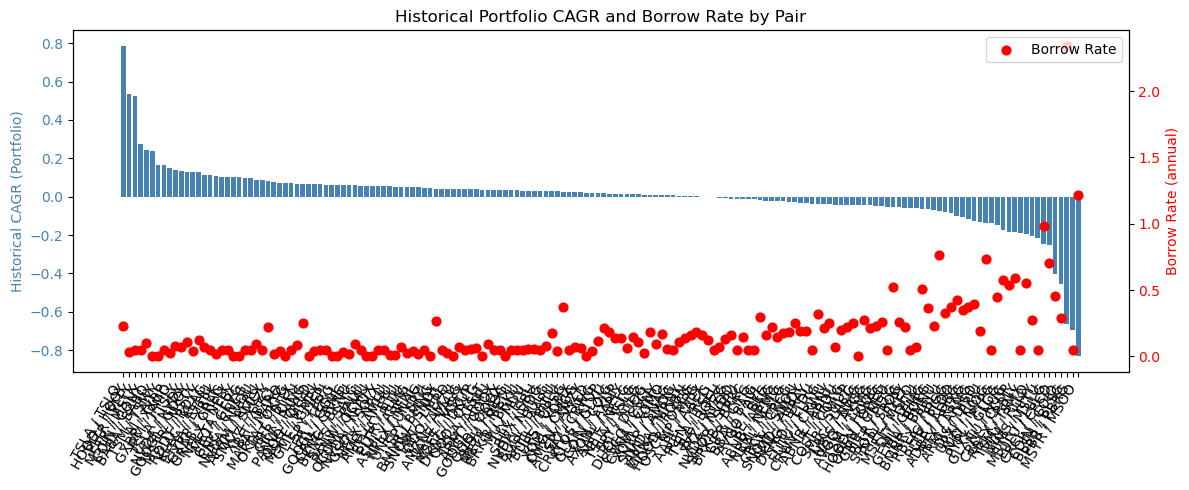

In [198]:
# Create a compact label like "NVDA / NVDU"
results_df_mc["PairLabel"] = results_df_mc["Underlying"] + " / " + results_df_mc["ETF"]

# Sort by historical portfolio CAGR
df_sorted = results_df_mc.sort_values("cagr_port_hist", ascending=False)

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(12, 5))

# Bar chart: historical CAGR
bars = ax1.bar(df_sorted["PairLabel"], df_sorted["cagr_port_hist"], color="steelblue")
ax1.set_ylabel("Historical CAGR (Portfolio)", color="steelblue")
ax1.tick_params(axis="y", labelcolor="steelblue")
ax1.set_xticklabels(df_sorted["PairLabel"], rotation=60, ha="right")
ax1.set_title("Historical Portfolio CAGR and Borrow Rate by Pair")

# Secondary axis for borrow rate
ax2 = ax1.twinx()
ax2.scatter(
    df_sorted["PairLabel"],
    df_sorted["borrow_annual"],
    color="red",
    s=40,
    label="Borrow Rate"
)
ax2.set_ylabel("Borrow Rate (annual)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Optional: add legend for borrow rate
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


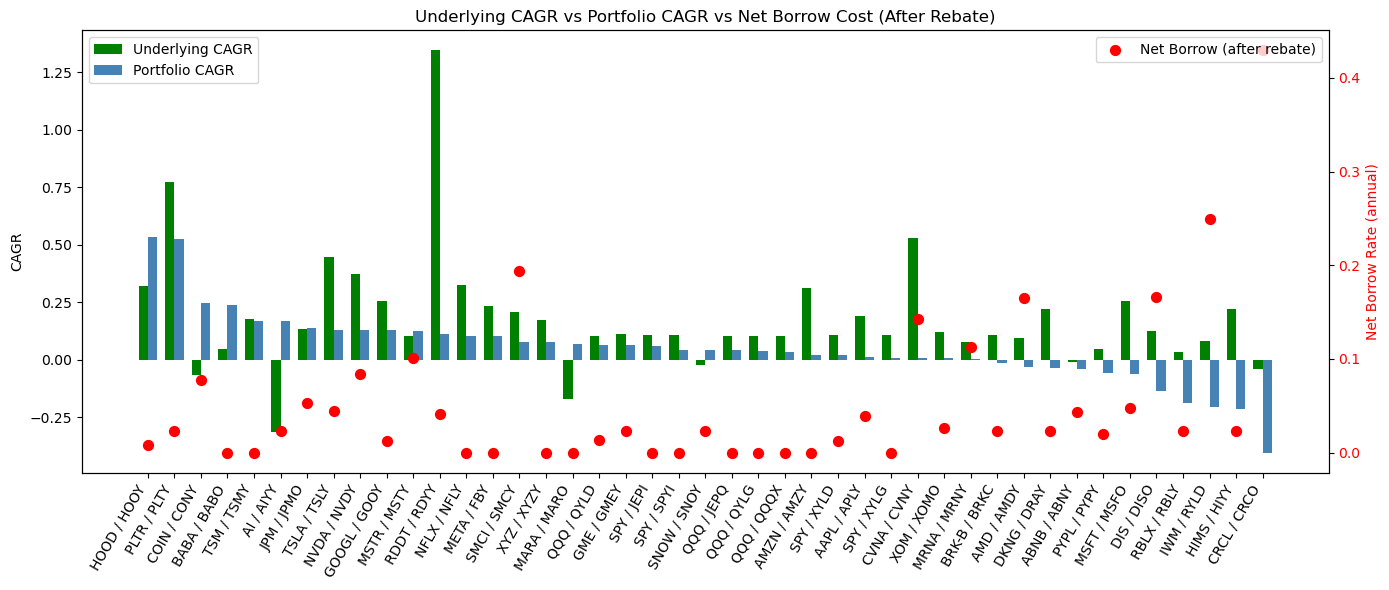

In [215]:
# Restrict to YieldMax tickers only
cc_etfs = set(income_df["ETF"].unique())
df = results_df_mc[results_df_mc["ETF"].isin(cc_etfs)].copy()

# Drop rows with ANY NaNs in the relevant columns
df = df.dropna(subset=["cagr_long_hist", "cagr_port_hist", "borrow_annual"])

# --- Apply rebate adjustment ---
risk_free = 0.053         # 5.3% Fed Funds
rebate_fraction = 0.50
rebate_rate = rebate_fraction * risk_free   # ≈ 2.65%

df["net_borrow"] = df["borrow_annual"] - rebate_rate
df["net_borrow"] = df["net_borrow"].clip(lower=0)  # no negative borrow cost

# Make compact label like: "NVDA / NVDY"
df["PairLabel"] = df["Underlying"] + " / " + df["ETF"]

# Sort by portfolio CAGR
df_sorted = df.sort_values("cagr_port_hist", ascending=False)

# Extract data
labels = df_sorted["PairLabel"]
under_cagr = df_sorted["cagr_long_hist"]
port_cagr = df_sorted["cagr_port_hist"]
net_borrow = df_sorted["net_borrow"]

x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Underlying vs Portfolio CAGR bars ---
ax1.bar(x - width/2, under_cagr, width, label="Underlying CAGR", color="green")
ax1.bar(x + width/2, port_cagr, width, label="Portfolio CAGR", color="steelblue")

ax1.set_ylabel("CAGR", color="black")
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=60, ha="right")
ax1.set_title("Underlying CAGR vs Portfolio CAGR vs Net Borrow Cost (After Rebate)")
ax1.legend(loc="upper left")

# --- Secondary axis (Net Borrow Rate) ---
ax2 = ax1.twinx()
ax2.scatter(x, net_borrow, color="red", s=50, label="Net Borrow (after rebate)")
ax2.set_ylabel("Net Borrow Rate (annual)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


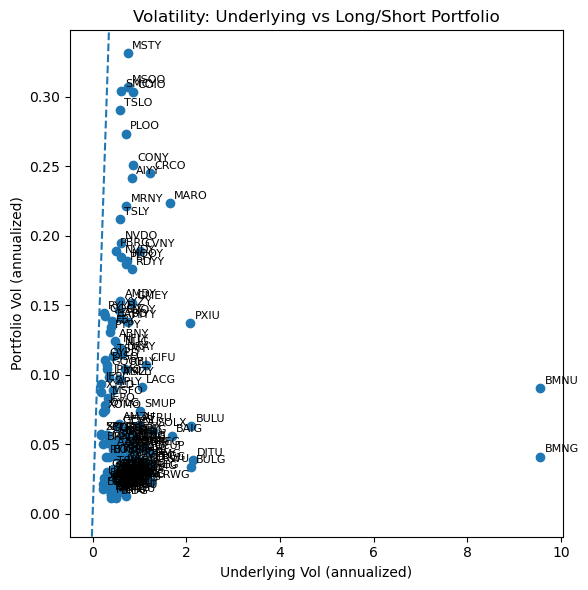

In [200]:
plt.figure(figsize=(6, 6))
plt.scatter(results_df_mc["vol_long_hist"], results_df_mc["vol_port_hist"])

for _, row in results_df_mc.iterrows():
    plt.annotate(
        row["ETF"],
        (row["vol_long_hist"], row["vol_port_hist"]),
        fontsize=8,
        xytext=(3, 3),
        textcoords="offset points",
    )

plt.xlabel("Underlying Vol (annualized)")
plt.ylabel("Portfolio Vol (annualized)")
plt.title("Volatility: Underlying vs Long/Short Portfolio")
plt.axline((0, 0), slope=1, linestyle="--")  # 45° line for parity
plt.tight_layout()
plt.show()


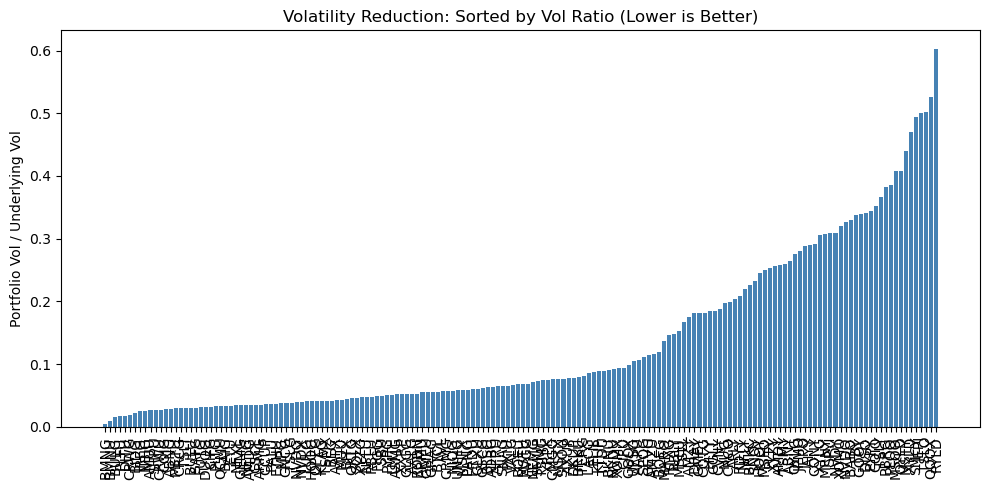

In [201]:
# Compute volatility ratio: Portfolio vol / Underlying vol
results_df_mc["vol_ratio"] = (
    results_df_mc["vol_port_hist"] / results_df_mc["vol_long_hist"]
)

# Sort by lowest ratio (most volatility reduction)
vol_ratio_sorted = results_df_mc.sort_values("vol_ratio")
vol_ratio_sorted[["ETF", "Underlying", "vol_ratio"]]
plt.figure(figsize=(10, 5))

plt.bar(
    vol_ratio_sorted["ETF"],
    vol_ratio_sorted["vol_ratio"],
    color="steelblue"
)

plt.xticks(rotation=90)
plt.ylabel("Portfolio Vol / Underlying Vol")
plt.title("Volatility Reduction: Sorted by Vol Ratio (Lower is Better)")
plt.tight_layout()
plt.show()


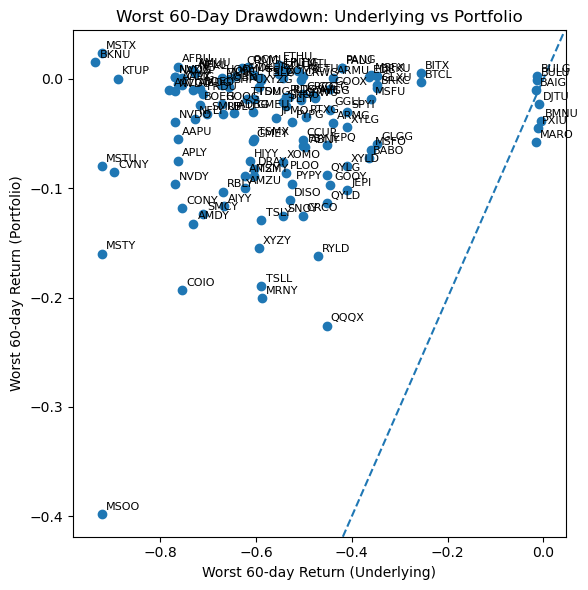

In [202]:
plt.figure(figsize=(6, 6))
plt.scatter(results_df_mc["worst60_long_hist"], results_df_mc["worst60_port_hist"])

for _, row in results_df_mc.iterrows():
    plt.annotate(
        row["ETF"],
        (row["worst60_long_hist"], row["worst60_port_hist"]),
        fontsize=8,
        xytext=(3, 3),
        textcoords="offset points",
    )

plt.xlabel("Worst 60-day Return (Underlying)")
plt.ylabel("Worst 60-day Return (Portfolio)")
plt.title("Worst 60-Day Drawdown: Underlying vs Portfolio")
plt.axline((0, 0), slope=1, linestyle="--")
plt.tight_layout()
plt.show()


In [203]:
def simulate_pair_mc_full(
    long_ret,
    etf_ret,
    w_long,
    w_short,
    borrow_annual,
    horizon_days=252*5,
    n_sims=1000,
    random_state=None,
    trading_days=252,
):
    """
    Alternative MC for a single pair that returns the full array of simulated CAGRs
    (instead of just percentiles).
    """
    rng = np.random.default_rng(random_state)

    # historical joint returns (long underlying, long ETF)
    ret_mat = pd.concat(
        [long_ret.rename("long"), etf_ret.rename("etf")],
        axis=1
    ).dropna()

    if ret_mat.empty or ret_mat.shape[0] < 3:
        return None

    mu  = ret_mat.mean().values
    cov = ret_mat.cov().values

    borrow_daily = borrow_annual / trading_days

    sim_cagrs = []

    for _ in range(n_sims):
        # simulate joint daily returns
        sim_daily = rng.multivariate_normal(mu, cov, size=horizon_days)
        sim_long = sim_daily[:, 0]
        sim_etf  = sim_daily[:, 1]

        # portfolio daily returns with borrow drag
        sim_port = (
            w_long * sim_long +
            w_short * sim_etf -
            abs(w_short) * borrow_daily
        )

        T = len(sim_port)
        cumulative = (1 + sim_port).prod()
        cagr = cumulative ** (trading_days / T) - 1.0
        sim_cagrs.append(cagr)

    return np.array(sim_cagrs)


MSTR / MSTX
Mean CAGR: 0.2742503847559827
P10: 0.23401411128541838
P50 (median): 0.27306578915310653
P90: 0.3159474529626222


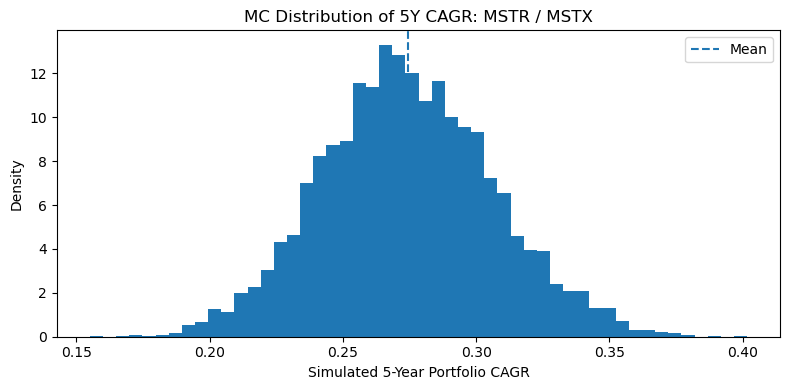

In [204]:
etf = "MSTX"
pair_to_view = results_df_mc[results_df_mc["ETF"] == etf].iloc[0]

print(pair_to_view["Underlying"], "/", pair_to_view["ETF"])

# Rebuild daily returns for this pair
und = pair_to_view["Underlying"]
etf = pair_to_view["ETF"]

long_tr = get_total_return_series(und, start=None, end=None)
etf_tr  = get_total_return_series(etf, start=None, end=None)

# Use the same trading_days as before
trading_days = 252

# Recompute leg returns
_, long_ret  = compute_leg_stats(long_tr, trading_days=trading_days)
_, etf_ret   = compute_leg_stats(etf_tr,  trading_days=trading_days)

# Pull the pair-specific weights and borrow from results_df_mc
w_long_pair   = float(pair_to_view["w_long"])
w_short_pair  = float(pair_to_view["w_short"])
borrow_annual = float(pair_to_view["borrow_annual"])

# Set MC parameters (match what you used in analyze_pairs_with_mc)
horizon_days = 252 * 5
n_sims = 5000

# Run alternative MC for this pair
sim_cagrs = simulate_pair_mc_full(
    long_ret=long_ret,
    etf_ret=etf_ret,
    w_long=w_long_pair,
    w_short=w_short_pair,
    borrow_annual=borrow_annual,
    horizon_days=horizon_days,
    n_sims=n_sims,
    random_state=42,
    trading_days=trading_days,
)

# Quick summary
print("Mean CAGR:", sim_cagrs.mean())
print("P10:", np.percentile(sim_cagrs, 10))
print("P50 (median):", np.percentile(sim_cagrs, 50))
print("P90:", np.percentile(sim_cagrs, 90))

# Plot distribution
plt.figure(figsize=(8, 4))
plt.hist(sim_cagrs, bins=50, density=True)
plt.axvline(sim_cagrs.mean(), linestyle="--", label="Mean")
plt.xlabel("Simulated 5-Year Portfolio CAGR")
plt.ylabel("Density")
plt.title(f"MC Distribution of 5Y CAGR: {und} / {etf}")
plt.legend()
plt.tight_layout()
plt.show()


In [205]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def compute_beta(etf, underlying, start=None, end=None):
    # Download prices
    data = yf.download([etf, underlying], period='max')["Close"].dropna()

    # Compute daily returns
    ret = data.pct_change().dropna()
    etf_ret = ret[etf].values.reshape(-1, 1)
    und_ret = ret[underlying].values.reshape(-1, 1)

    # Run linear regression: ETF_ret ~ beta * Underlying_ret
    model = LinearRegression().fit(und_ret, etf_ret)
    beta = model.coef_[0][0]
    alpha = model.intercept_[0]

    return beta, alpha, ret

# Example: PLTY / PLTR
beta, alpha, ret = compute_beta("PLTY", "PLTR")
print("Beta (PLTY vs PLTR):", beta)
print("Alpha:", alpha)

beta, alpha, ret = compute_beta("GOOY", "GOOGL")
print("Beta (GOOY vs GOOGL):", beta)
print("Alpha:", alpha)


C:\Users\werdn\AppData\Local\Temp\ipykernel_22752\237220497.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([etf, underlying], period='max')["Close"].dropna()
[*********************100%***********************]  2 of 2 completed
C:\Users\werdn\AppData\Local\Temp\ipykernel_22752\237220497.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([etf, underlying], period='max')["Close"].dropna()


Beta (PLTY vs PLTR): 0.7879194837945345
Alpha: -0.0006882360190389623


[*********************100%***********************]  2 of 2 completed


Beta (GOOY vs GOOGL): 0.7399377537085734
Alpha: -0.00024367616227146066


PLTR / PLTY
Mean CAGR: 0.5279529889364021
P10: 0.3772835351908419
P50 (median): 0.5213994579409927
P90: 0.6871357735349023


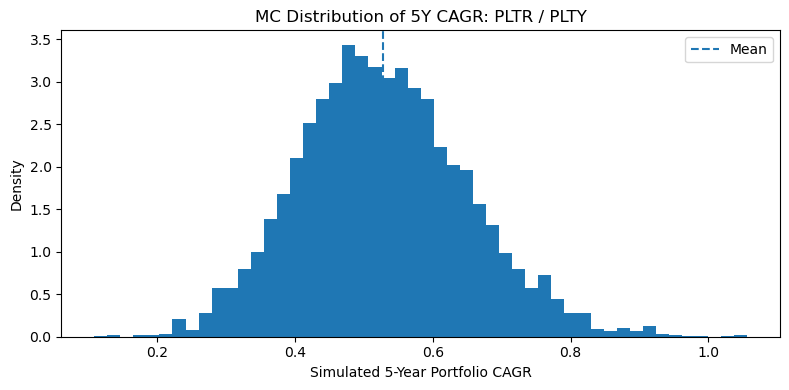

In [206]:
etf = "PLTY"
pair_to_view = results_df_mc[results_df_mc["ETF"] == etf].iloc[0]

print(pair_to_view["Underlying"], "/", pair_to_view["ETF"])

# Rebuild daily returns for this pair
und = pair_to_view["Underlying"]
etf = pair_to_view["ETF"]

long_tr = get_total_return_series(und, start=None, end=None)
etf_tr  = get_total_return_series(etf, start=None, end=None)

# Use the same trading_days as before
trading_days = 252

# Recompute leg returns
_, long_ret  = compute_leg_stats(long_tr, trading_days=trading_days)
_, etf_ret   = compute_leg_stats(etf_tr,  trading_days=trading_days)

# Pull the pair-specific weights and borrow from results_df_mc
w_long_pair   = float(pair_to_view["w_long"])
w_short_pair  = float(pair_to_view["w_short"])
borrow_annual = float(pair_to_view["borrow_annual"])

# Set MC parameters (match what you used in analyze_pairs_with_mc)
horizon_days = 252 * 5
n_sims = 5000

# Run alternative MC for this pair
sim_cagrs = simulate_pair_mc_full(
    long_ret=long_ret,
    etf_ret=etf_ret,
    w_long=w_long_pair,
    w_short=w_short_pair,
    borrow_annual=borrow_annual,
    horizon_days=horizon_days,
    n_sims=n_sims,
    random_state=42,
    trading_days=trading_days,
)

# Quick summary
print("Mean CAGR:", sim_cagrs.mean())
print("P10:", np.percentile(sim_cagrs, 10))
print("P50 (median):", np.percentile(sim_cagrs, 50))
print("P90:", np.percentile(sim_cagrs, 90))

# Plot distribution
plt.figure(figsize=(8, 4))
plt.hist(sim_cagrs, bins=50, density=True)
plt.axvline(sim_cagrs.mean(), linestyle="--", label="Mean")
plt.xlabel("Simulated 5-Year Portfolio CAGR")
plt.ylabel("Density")
plt.title(f"MC Distribution of 5Y CAGR: {und} / {etf}")
plt.legend()
plt.tight_layout()
plt.show()


NVDA / NVDU
Mean CAGR: 0.08938190718104767
P10: 0.05654722723254007
P50 (median): 0.08850667767763998
P90: 0.12331292049397735


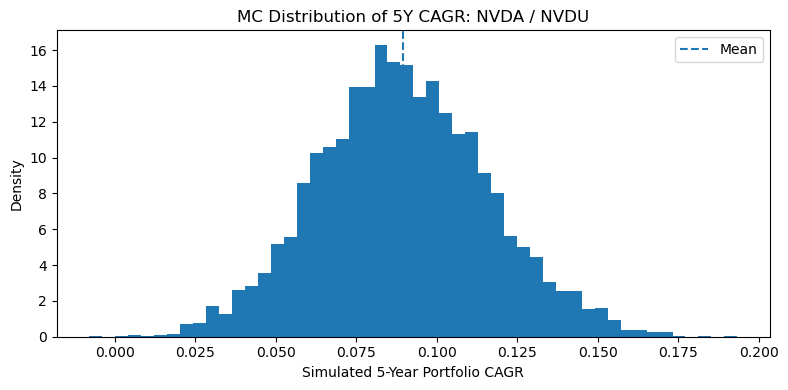

In [207]:
etf = "NVDU"
pair_to_view = results_df_mc[results_df_mc["ETF"] == etf].iloc[0]

print(pair_to_view["Underlying"], "/", pair_to_view["ETF"])

# Rebuild daily returns for this pair
und = pair_to_view["Underlying"]
etf = pair_to_view["ETF"]

long_tr = get_total_return_series(und, start=None, end=None)
etf_tr  = get_total_return_series(etf, start=None, end=None)

# Use the same trading_days as before
trading_days = 252

# Recompute leg returns
_, long_ret  = compute_leg_stats(long_tr, trading_days=trading_days)
_, etf_ret   = compute_leg_stats(etf_tr,  trading_days=trading_days)

# Pull the pair-specific weights and borrow from results_df_mc
w_long_pair   = float(pair_to_view["w_long"])
w_short_pair  = float(pair_to_view["w_short"])
borrow_annual = float(pair_to_view["borrow_annual"])

# Set MC parameters (match what you used in analyze_pairs_with_mc)
horizon_days = 252 * 5
n_sims = 5000

# Run alternative MC for this pair
sim_cagrs = simulate_pair_mc_full(
    long_ret=long_ret,
    etf_ret=etf_ret,
    w_long=w_long_pair,
    w_short=w_short_pair,
    borrow_annual=borrow_annual,
    horizon_days=horizon_days,
    n_sims=n_sims,
    random_state=42,
    trading_days=trading_days,
)

# Quick summary
print("Mean CAGR:", sim_cagrs.mean())
print("P10:", np.percentile(sim_cagrs, 10))
print("P50 (median):", np.percentile(sim_cagrs, 50))
print("P90:", np.percentile(sim_cagrs, 90))

# Plot distribution
plt.figure(figsize=(8, 4))
plt.hist(sim_cagrs, bins=50, density=True)
plt.axvline(sim_cagrs.mean(), linestyle="--", label="Mean")
plt.xlabel("Simulated 5-Year Portfolio CAGR")
plt.ylabel("Density")
plt.title(f"MC Distribution of 5Y CAGR: {und} / {etf}")
plt.legend()
plt.tight_layout()
plt.show()


In [208]:
# --- 1. Extract pairs ---

ym_df["Underlying"] = ym_df["Underlying"].str.replace(".", "-", regex=False)
pairs = list(zip(ym_df["Underlying"], ym_df["ETF"]))

# --- 2. Load all TR price series into a unified DataFrame ---
price_dict = {}

for und, etf in pairs:
    # Get total return series
    tr_und = get_total_return_series(und)
    tr_etf = get_total_return_series(etf)
    
    if not tr_und.empty:
        price_dict[f"{und}_TR"] = tr_und
    if not tr_etf.empty:
        price_dict[f"{etf}_TR"] = tr_etf

# Combine into one aligned DataFrame, KEEPING all dates
prices = pd.DataFrame(price_dict)   # <-- no dropna here
prices.tail()


,ABNB_TR,ABNY_TR,AI_TR,AIYY_TR,AMD_TR,AMDY_TR,AMZN_TR,AMZY_TR,AAPL_TR,APLY_TR,BABA_TR,BABO_TR,BRK-B_TR,BRKC_TR,COIN_TR,CONY_TR,CRCL_TR,CRCO_TR,CVNA_TR,CVNY_TR,DIS_TR,DISO_TR,DKNG_TR,DRAY_TR,META_TR,FBY_TR,GME_TR,GMEY_TR,GOOGL_TR,GOOY_TR,HIMS_TR,HIYY_TR,HOOD_TR,HOOY_TR,JPM_TR,JPMO_TR,MARA_TR,MARO_TR,MRNA_TR,MRNY_TR,MSFT_TR,MSFO_TR,MSTR_TR,MSTY_TR,NFLX_TR,NFLY_TR,NVDA_TR,NVDY_TR,PLTR_TR,PLTY_TR,PYPL_TR,PYPY_TR,RBLX_TR,RBLY_TR,RDDT_TR,RDYY_TR,SMCI_TR,SMCY_TR,SNOW_TR,SNOY_TR,TSLA_TR,TSLY_TR,TSM_TR,TSMY_TR,XOM_TR,XOMO_TR,XYZ_TR,XYZY_TR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-12-19 00:00:00-05:00,135.279999,89.936154,14.44,73.296129,213.429993,161.313902,227.350006,35.059892,357.068460,27.806409,157.823468,30.404780,494.529999,49.736284,245.119995,353.596445,86.129997,32.981971,450.220001,84.829755,180.714363,25.281606,34.209999,39.891370,663.334107,34.823694,33.505842,46.759602,309.499869,33.743877,35.560001,32.656188,121.349998,91.820602,1530.107751,28.970339,10.18,21.385309,33.799999,70.606230,793.803291,30.562539,164.820007,201.439802,94.389999,35.035844,197.387337,75.884870,193.380005,148.572651,59.949303,108.670759,81.940002,37.202011,233.190002,48.121384,31.110001,29.934784,222.460007,32.297510,481.200012,341.890542,577.076775,29.287843,2064.611816,20.303619,65.330002,124.905449
2025-12-22 00:00:00-05:00,136.949997,90.427295,14.62,73.855334,214.949997,162.245623,228.429993,35.245674,353.545644,27.723404,159.056231,30.653073,499.950012,50.084480,247.899994,357.593764,87.000000,33.178924,433.589996,81.662550,182.566343,25.414588,34.900002,40.371711,666.083002,34.823694,32.359706,45.732542,312.139823,33.953757,35.049999,32.458433,122.370003,93.407180,1558.470795,29.354172,10.13,21.461503,34.900002,72.318149,792.169682,30.523307,164.320007,201.691529,93.230003,34.746291,200.331949,76.625207,193.979996,149.018190,59.999418,109.612076,81.980003,37.515271,233.149994,48.296370,31.070000,30.040688,226.839996,32.845811,488.730011,347.168724,585.724412,29.638828,2090.443775,20.391741,65.150002,125.084663
2025-12-23 00:00:00-05:00,136.490005,90.538751,14.02,72.177711,214.899994,162.372670,232.139999,35.457997,355.359213,27.868663,159.340700,30.720789,500.510010,50.005995,242.300003,351.681066,82.730003,32.358286,437.350006,82.368755,183.930967,25.562347,34.540001,40.136047,669.546837,35.016545,31.823850,44.658152,316.744643,34.396834,34.799999,32.191100,120.239998,92.094152,1572.169923,29.664895,9.86,21.055132,32.290001,68.184491,795.322535,30.523307,157.880005,194.769208,93.500000,34.746291,206.352054,78.476059,194.130005,149.594768,59.548370,108.736123,80.989998,37.136327,225.820007,47.271448,30.760000,29.899486,225.100006,32.715263,485.559998,346.402534,593.053982,30.028812,2112.913996,20.515115,64.940002,124.722580
2025-12-24 00:00:00-05:00,136.779999,90.754096,14.04,71.977997,215.039993,162.542077,232.380005,35.537620,357.251103,27.910164,158.107953,30.675646,501.339996,49.993838,239.729996,348.349983,82.639999,32.035084,441.570007,83.288949,185.977897,25.857866,34.459999,40.051054,672.174905,35.181849,32.047125,44.990642,316.482653,34.350193,34.669998,32.112974,120.440002,92.732425,1587.798627,29.792839,9.94,21.029733,32.750000,68.894311,797.233830,30.621388,158.710007,195.713160,93.639999,34.891067,205.697689,78.317416,194.169998,149.385100,60.179838,109.591159,81.879997,37.388956,225.850006,47.033967,30.549999,29.793582,221.929993,32.271400,485.399994,346.572802,596.748662,30.048312,2109.375423,20.530977,66.050003,126.825600
2025-12-26 00:00:00-05:00,136.820007,89.874571,13.99,70.979412,214.990005,160.975088,232.520004,35.404918,356.716155,27.702655,160.404878,30.698219,498.299988,49.640781,236.899994,340.771696,81.269997,31.173416,438.470001,81.534147,184.483306,25.594010,34.880001,40.060454,667.885381,34.768591,31.392190,43.806920,315.898248,34.140316,34.310001,31.553283,118.129997,89.522810,1581.720790,29.619567,9.59,20.191591,31.200001,64.718898,796.727415,30.464456,158.809998,192.755430,

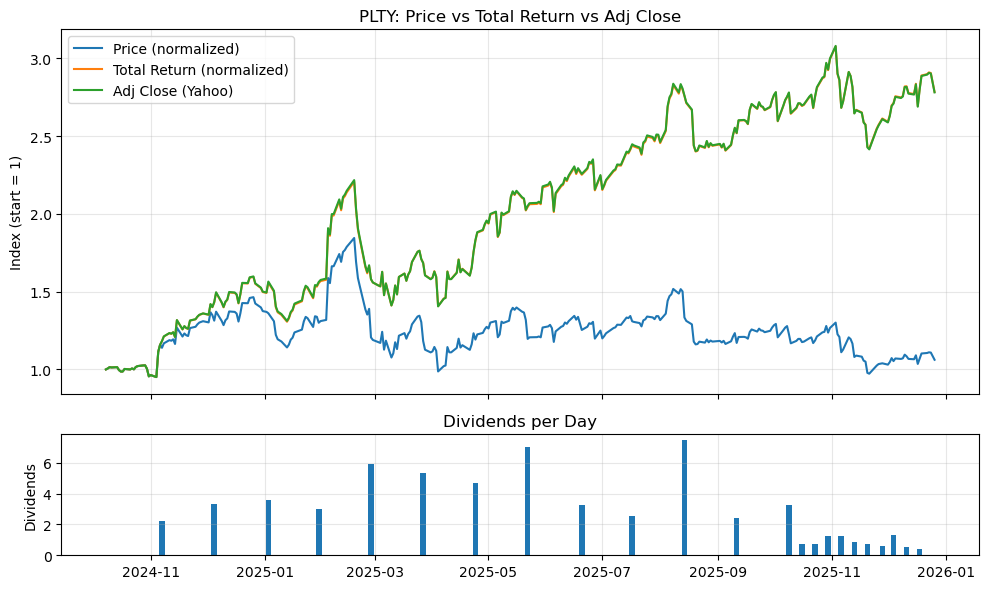

                               Close  Dividends
Date                                           
2024-11-07 00:00:00-05:00  58.577000      2.201
2024-12-05 00:00:00-05:00  67.547997      3.348
2025-01-03 00:00:00-05:00  69.989998      3.589
2025-01-30 00:00:00-05:00  66.860001      2.983
2025-02-27 00:00:00-05:00  62.000000      5.938
Price-only return: -0.01706551121768307
Total-return step: 0.019867735998939873


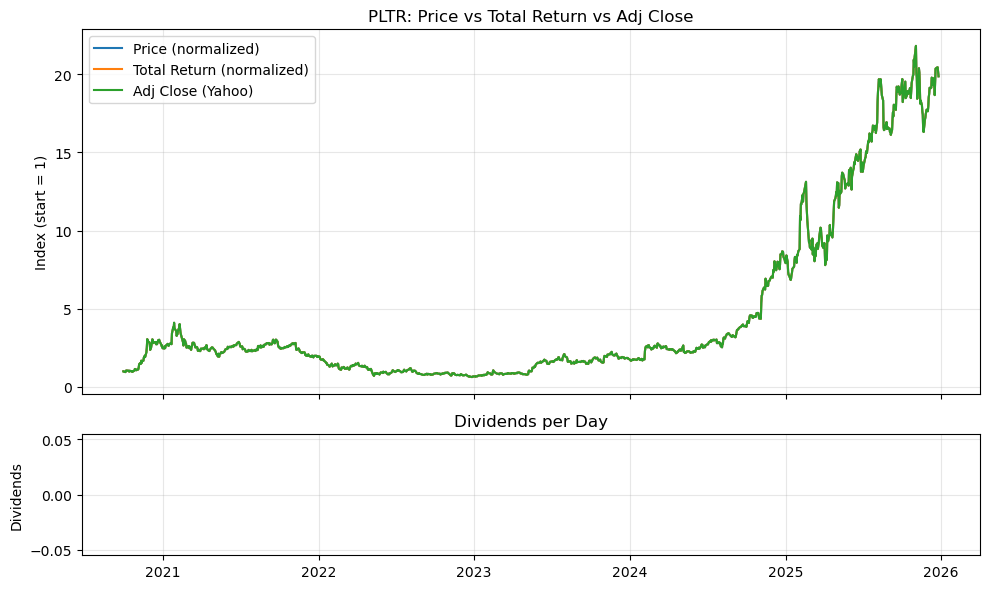

In [209]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

def debug_tr_vs_adj(ticker, start=None, end=None):
    t = yf.Ticker(ticker)

    # Raw (unadjusted) with dividends
    raw = t.history(period='max',
                    auto_adjust=False, actions=True)

    # Yahoo's adjusted series (adjusted for splits + dividends)
    adj = t.history(period='max',
                    auto_adjust=True, actions=False)

    if raw.empty or adj.empty:
        print(f"No data for {ticker}")
        return

    close = raw["Close"]
    divs  = raw.get("Dividends", pd.Series(0.0, index=raw.index))

    # Your TR logic
    divs = divs.reindex(close.index, fill_value=0.0)
    rel = (close + divs) / close.shift(1)
    rel.iloc[0] = 1.0
    tr = close.iloc[0] * rel.cumprod()
    tr.name = "TR"

    df = pd.DataFrame({
        "Close": close,
        "TR": tr,
        "AdjClose": adj["Close"],
        "Dividends": divs,
    }).dropna(subset=["Close", "TR", "AdjClose"])

    # Normalize all price-like series to 1 at start
    df["Close_norm"]    = df["Close"]    / df["Close"].iloc[0]
    df["TR_norm"]       = df["TR"]       / df["TR"].iloc[0]
    df["AdjClose_norm"] = df["AdjClose"] / df["AdjClose"].iloc[0]

    # --- Plot ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6),
                                   sharex=True,
                                   gridspec_kw={"height_ratios": [3, 1]})

    ax1.plot(df.index, df["Close_norm"],    label="Price (normalized)")
    ax1.plot(df.index, df["TR_norm"],       label="Total Return (normalized)")
    ax1.plot(df.index, df["AdjClose_norm"], label="Adj Close (Yahoo)")
    ax1.set_ylabel("Index (start = 1)")
    ax1.set_title(f"{ticker}: Price vs Total Return vs Adj Close")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.bar(df.index, df["Dividends"], width=3, align="center")
    ax2.set_ylabel("Dividends")
    ax2.set_title("Dividends per Day")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df

# Example for PLTY
df_plty = debug_tr_vs_adj("PLTY")

# Show rows where there is a non-zero dividend
div_days = df_plty[df_plty["Dividends"] != 0]
print(div_days[["Close", "Dividends"]].head())

# For a single ex-div day, compare price vs TR return
d = div_days.index[0]
prev = df_plty.loc[:d].iloc[-2]  # previous trading day
curr = df_plty.loc[d]

price_ret = curr["Close"] / prev["Close"] - 1
tr_ret    = (curr["Close"] + curr["Dividends"]) / prev["Close"] - 1

print("Price-only return:", price_ret)
print("Total-return step:", tr_ret)

df_plty = debug_tr_vs_adj("PLTR")



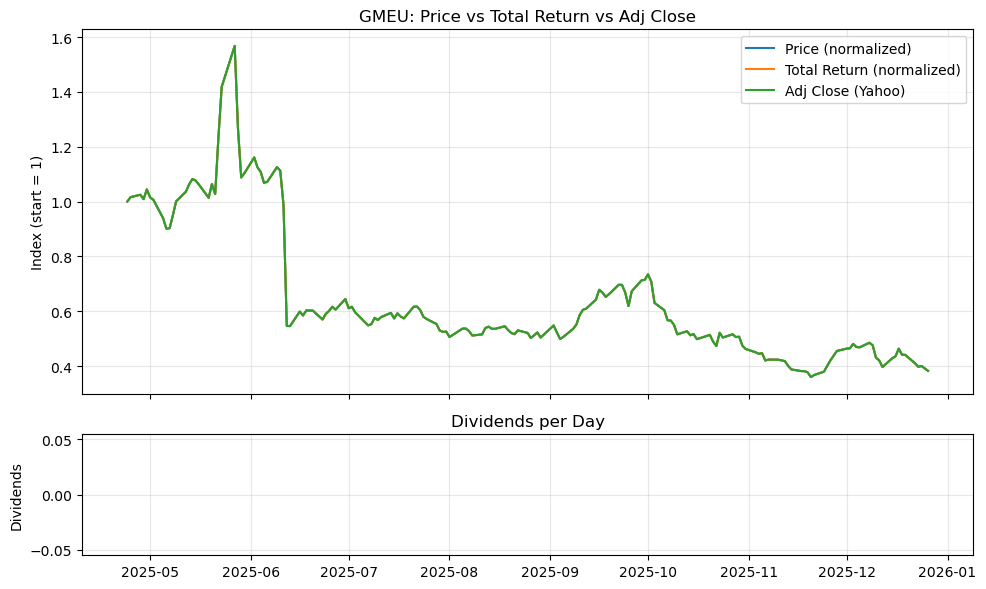

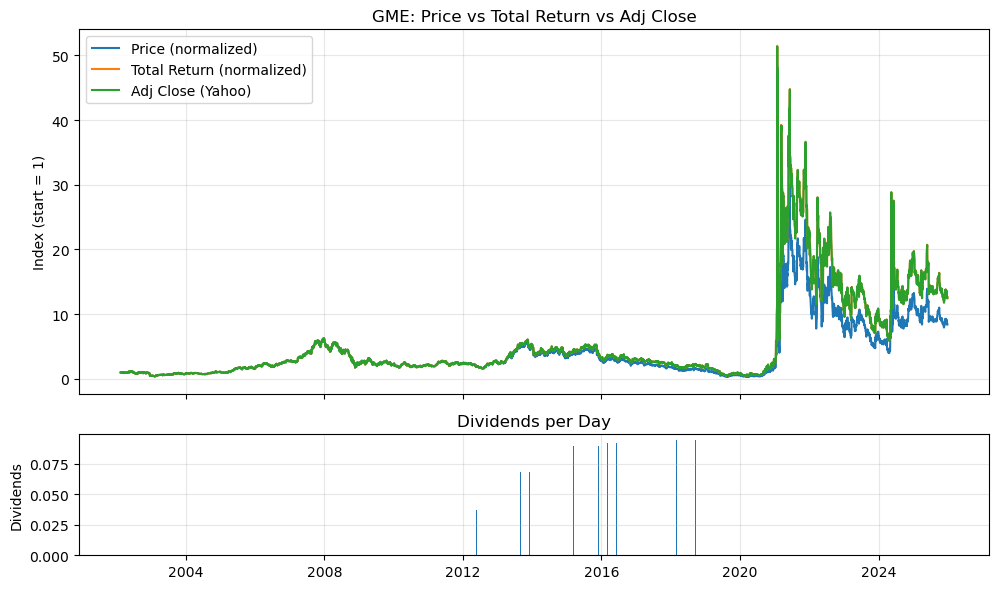

In [210]:
def debug_tr_vs_adj(ticker, start=None, end=None):
    t = yf.Ticker(ticker)

    # Raw (unadjusted) with dividends
    raw = t.history(period='max',
                    auto_adjust=False, actions=True)

    # Yahoo's adjusted series (adjusted for splits + dividends)
    adj = t.history(period='max',
                    auto_adjust=True, actions=False)

    if raw.empty or adj.empty:
        print(f"No data for {ticker}")
        return

    close = raw["Close"]
    divs  = raw.get("Dividends", pd.Series(0.0, index=raw.index))

    # Your TR logic
    divs = divs.reindex(close.index, fill_value=0.0)
    rel = (close + divs) / close.shift(1)
    rel.iloc[0] = 1.0
    tr = close.iloc[0] * rel.cumprod()
    tr.name = "TR"

    df = pd.DataFrame({
        "Close": close,
        "TR": tr,
        "AdjClose": adj["Close"],
        "Dividends": divs,
    }).dropna(subset=["Close", "TR", "AdjClose"])

    # Normalize all price-like series to 1 at start
    df["Close_norm"]    = df["Close"]    / df["Close"].iloc[0]
    df["TR_norm"]       = df["TR"]       / df["TR"].iloc[0]
    df["AdjClose_norm"] = df["AdjClose"] / df["AdjClose"].iloc[0]

    # --- Plot ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6),
                                   sharex=True,
                                   gridspec_kw={"height_ratios": [3, 1]})

    ax1.plot(df.index, df["Close_norm"],    label="Price (normalized)")
    ax1.plot(df.index, df["TR_norm"],       label="Total Return (normalized)")
    ax1.plot(df.index, df["AdjClose_norm"], label="Adj Close (Yahoo)")
    ax1.set_ylabel("Index (start = 1)")
    ax1.set_title(f"{ticker}: Price vs Total Return vs Adj Close")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.bar(df.index, df["Dividends"], width=3, align="center")
    ax2.set_ylabel("Dividends")
    ax2.set_title("Dividends per Day")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df

# Example for GMEU
df_gmeu = debug_tr_vs_adj("GMEU")

# Show rows where there is a non-zero dividend
div_days = df_gmeu[df_gmeu["Dividends"] != 0]
# print(div_days[["Close", "Dividends"]].head())

# # For a single ex-div day, compare price vs TR return
# d = div_days.index[0]
# prev = df_gmeu.loc[:d].iloc[-2]  # previous trading day
# curr = df_gmeu.loc[d]

# price_ret = curr["Close"] / prev["Close"] - 1
# tr_ret    = (curr["Close"] + curr["Dividends"]) / prev["Close"] - 1

# print("Price-only return:", price_ret)
# print("Total-return step:", tr_ret)

df_gme = debug_tr_vs_adj("GME")

